# **Age and Gender Distortion Analysis**
### Age and Gender Correlations

,n,r,CI95%,p-val,BF10,power
pearson,3495,0.872559,"[0.8644, 0.8802]",0.0,inf,1.0


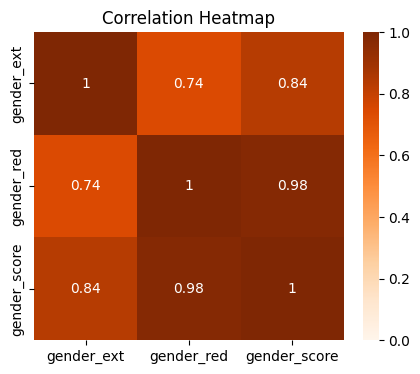

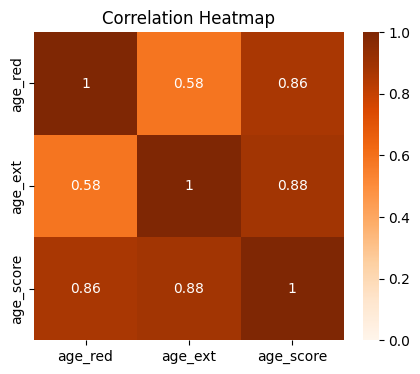

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from pingouin import bayesfactor_pearson
import statsmodels.stats.power as smp
from IPython.display import display

# Load data
df = pd.read_csv("data/GPT2-large-dimensions.csv")

# Correlation variables
x = df["gender.main"]
y = df["age.main"]

# Sample size
n = len(df)

# Pearson correlation
r, p = pearsonr(x, y)

# 95% CI (Fisher z-transform)
zr = np.arctanh(r)
se = 1 / np.sqrt(n - 3)
lo = np.tanh(zr - 1.96 * se)
hi = np.tanh(zr + 1.96 * se)
ci_95 = f"[{lo:.4f}, {hi:.4f}]"

# Bayes Factor BF10
BF10 = bayesfactor_pearson(r, n)

# Statistical power
analysis = smp.TTestPower()
power = analysis.solve_power(effect_size=r, nobs=n, alpha=0.05)

# Output
out = pd.DataFrame({
    "n": [n],
    "r": [r],
    "CI95%": [ci_95],
    "p-val": [p],
    "BF10": [BF10],
    "power": [power]
}, index=["pearson"])
display(out)

gender_cols = {
    "gender_ext": "gender.ext",
    "gender_red": "gender.red",
    "gender_score": "gender.main",
}

gender_matrix = pd.DataFrame(index=gender_cols.keys(), columns=gender_cols.keys(), dtype=float)

# Gender Matrix
for i, label_i in enumerate(gender_cols):
    for j, label_j in enumerate(gender_cols):
        x = df[gender_cols[label_i]]
        y = df[gender_cols[label_j]]
        r, _ = pearsonr(x, y)
        gender_matrix.loc[label_i, label_j] = abs(r)

age_cols = {
    "age_red": "age.red",
    "age_ext": "age.ext",
    "age_score": "age.main",
}

age_matrix = pd.DataFrame(index=age_cols.keys(), columns=age_cols.keys(), dtype=float)

# Age Matrix
for i, label_i in enumerate(age_cols):
    for j, label_j in enumerate(age_cols):
        x = df[age_cols[label_i]]
        y = df[age_cols[label_j]]
        r, _ = pearsonr(x, y)
        age_matrix.loc[label_i, label_j] = abs(r)

def plot_heatmap(matrix, title):
    plt.figure(figsize=(5,4))
    sns.heatmap(matrix, annot=True, cmap="Oranges", vmin=0, vmax=1, )
    plt.title(title)
    plt.show()

# Plot the heatmaps
plot_heatmap(gender_matrix, "Correlation Heatmap")
plot_heatmap(age_matrix, "Correlation Heatmap")


### OLS Regression Model: `Normalized Age` ~ Normalized Gender

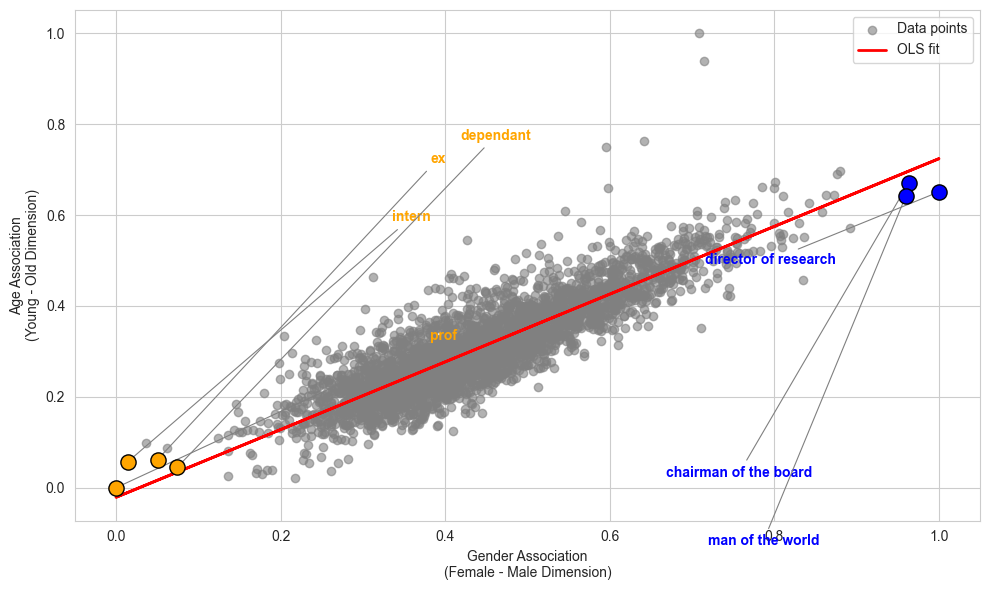

In [2]:
import statsmodels.api as sm
from statsmodels.stats.stattools import omni_normtest, jarque_bera
from datetime import datetime
import plotly.graph_objects as go
from IPython.display import HTML, display



# Load dataset
plot_df = df[['gender_norm.main', 'age_norm.main', 'Social.Category']].dropna()
x = plot_df['gender_norm.main']
y = plot_df['age_norm.main']


# Fit OLS regression
X_with_const = sm.add_constant(x)
model = sm.OLS(y, X_with_const).fit(cov_type='nonrobust')
y_pred = model.predict(X_with_const)


# Prepare OLS Regression HTML table
now = datetime.now()
left_info = pd.DataFrame({
    'Label': [
        'Dep. Variable', 'Model', 'Method', 'Date', 'Time', 
        'No. Observations', 'Df Residuals', 'Df Model', 'Covariance Type'
    ],
    'Value': [
        'age_norm.main', 'OLS', 'Least Squares', 
        now.strftime('%Y-%m-%d'), now.strftime('%H:%M:%S'),
        f"{int(model.nobs)}", f"{int(model.df_resid)}", f"{int(model.df_model)}",
        'Nonrobust'
    ]
})

fit_stats = pd.DataFrame({
    'Statistic': ['R-squared', 'Adj. R-squared', 'F-statistic', 'Prob (F-statistic)', 'Log-Likelihood', 'AIC', 'BIC'],
    'Value': [
        f"{model.rsquared:.3f}",
        f"{model.rsquared_adj:.3f}",
        f"{model.fvalue:.3e}",
        f"{model.f_pvalue:.3f}",
        f"{model.llf:.3f}",
        f"{model.aic:.3e}",
        f"{model.bic:.3e}"
    ]
})

# Basic Regression Data Table

max_len = max(len(left_info), len(fit_stats))
fit_html = "<table style='border-collapse: collapse; width:100%; font-family:Arial; font-size:14px;'>"
for i in range(max_len):
    left_text = f"{left_info.iloc[i,0]}: {left_info.iloc[i,1]}" if i < len(left_info) else ""
    right_text = f"{fit_stats.iloc[i,0]}: {fit_stats.iloc[i,1]}" if i < len(fit_stats) else ""
    fit_html += f"<tr><td style='padding:4px; border:1px solid black; text-align:left; vertical-align:top'>{left_text}</td>"
    fit_html += f"<td style='padding:4px; border:1px solid black; text-align:left; vertical-align:top'>{right_text}</td></tr>"
fit_html += "</table>"

# Coefficients table
coeff_table = model.summary2().tables[1].rename(index={'const':'Intercept'}).round(3)
coeff_html = "<table style='border-collapse: collapse; width:100%; font-family:Arial; font-size:14px;'>"
coeff_html += "<tr>" + "".join([f"<th style='border:1px solid black; padding:4px; text-align:left'>{col}</th>" for col in coeff_table.columns]) + "</tr>"
for idx, row in coeff_table.iterrows():
    coeff_html += "<tr><td style='border:1px solid black; padding:4px; text-align:left'>{}</td>".format(idx)
    coeff_html += "".join([f"<td style='border:1px solid black; padding:4px; text-align:left'>{val:.3f}</td>" for val in row])
    coeff_html += "</tr>"
coeff_html += "</table>"

# Residual diagnostics
omnibus_stat, omnibus_p = omni_normtest(model.resid)
jb_stat, jb_p, skew, kurtosis = jarque_bera(model.resid)
dw = sm.stats.stattools.durbin_watson(model.resid)

resid_left = ['Omnibus','Prob(Omnibus)','Durbin-Watson','Jarque-Bera (JB)']
resid_right = ['Prob(JB)','Skew','Kurtosis','Cond. No.']
resid_values_left = [f"{omnibus_stat:.3f}",f"{omnibus_p:.3f}",f"{dw:.3f}",f"{jb_stat:.3f}"]
resid_values_right = [f"{jb_p:.3f}",f"{skew:.3f}",f"{kurtosis:.3f}",f"{model.condition_number:.3f}"]

resid_html = "<table style='border-collapse: collapse; width:100%; font-family:Arial; font-size:14px;'>"
for l in range(4):
    resid_html += f"<tr><td style='padding:4px; border:1px solid black; text-align:left'>{resid_left[l]}: {resid_values_left[l]}</td>"
    resid_html += f"<td style='padding:4px; border:1px solid black; text-align:left'>{resid_right[l]}: {resid_values_right[l]}</td></tr>"
resid_html += "</table>"

display(HTML(f"<h3>OLS Regression Results</h3>{fit_html}{coeff_html}{resid_html}"))


# Identify outliers for both plots

sum_xy = x + y
top_right_idx = sum_xy[(x >= 0.9)].nlargest(4).index
bottom_left_idx = sum_xy.nsmallest(4).index


# Static Plot

plt.figure(figsize=(10,6))
sns.set_style("whitegrid")

plt.scatter(x, y, color='gray', alpha=0.6, label='Data points')
plt.plot(x, y_pred, color='red', linewidth=2, label='OLS fit')

ax = plt.gca()

def label_point_inside(ax, x_data, y_data, indices, color):
    for idx in indices:
        ax.scatter(x_data.loc[idx], y_data.loc[idx], s=120, edgecolor='black', color=color, zorder=5)
        dx = np.random.uniform(-0.4, -0.1) if x_data.loc[idx] > 0.5 else np.random.uniform(0.1,0.4)
        dy = np.random.uniform(-0.8, -0.1) if y_data.loc[idx] > 0.5 else np.random.uniform(0.1,0.8)
        ax.annotate(plot_df.loc[idx,'Social.Category'],
                    xy=(x_data.loc[idx], y_data.loc[idx]),
                    xytext=(x_data.loc[idx]+dx, y_data.loc[idx]+dy),
                    arrowprops=dict(arrowstyle='-', lw=0.8, color='gray'),
                    fontsize=10, weight='bold', color=color)

label_point_inside(ax, x, y, top_right_idx, color='blue')
label_point_inside(ax, x, y, bottom_left_idx, color='orange')

plt.xlabel("Gender Association\n(Female - Male Dimension)")
plt.ylabel("Age Association\n(Young - Old Dimension)")
plt.legend()
plt.tight_layout()
plt.show()

# Interactive HTML Plot

fig = go.Figure()

general_idx = plot_df.index.difference(top_right_idx.union(bottom_left_idx))
fig.add_trace(go.Scatter(
    x=plot_df.loc[general_idx, 'gender_norm.main'],
    y=plot_df.loc[general_idx, 'age_norm.main'],
    mode='markers',
    marker=dict(color='gray', size=8),
    name='Normal',
    hovertemplate='gender_norm: %{x}<br>age_norm: %{y}<br>social_category: %{text}',
    text=plot_df.loc[general_idx, 'Social.Category']
))

# Bottom-left outliers (orange, bigger)

fig.add_trace(go.Scatter(
    x=plot_df.loc[bottom_left_idx, 'gender_norm.main'],
    y=plot_df.loc[bottom_left_idx, 'age_norm.main'],
    mode='markers',
    marker=dict(color='orange', size=14),
    name='Bottom-left Outlier',
    hovertemplate='gender_norm: %{x}<br>age_norm: %{y}<br>social_category: %{text}',
    text=plot_df.loc[bottom_left_idx, 'Social.Category']
))

# Top-right outliers (blue, bigger)

fig.add_trace(go.Scatter(
    x=plot_df.loc[top_right_idx, 'gender_norm.main'],
    y=plot_df.loc[top_right_idx, 'age_norm.main'],
    mode='markers',
    marker=dict(color='blue', size=14),
    name='Top-right Outlier',
    hovertemplate='gender_norm: %{x}<br>age_norm: %{y}<br>social_category: %{text}',
    text=plot_df.loc[top_right_idx, 'Social.Category']
))

# Regression line

fig.add_trace(go.Scatter(
    x=x,
    y=y_pred,
    mode='lines',
    line=dict(color='red'),
    name='OLS Fit'
))

fig.update_layout(
    title="Interactive Regression Plot",
    xaxis_title="gender_norm",
    yaxis_title="age_norm",
    hovermode="closest"
)

fig.write_html("age_gender_regression_interactive.html", include_plotlyjs='cdn')


### Notes on Outliers

As we see, not all outliers were included in the highlighted set. This is because:

1. **Measurement Error:** Some extreme points could reflect errors in data collection or entry rather than true observations (ex. Old Woman found at top right of the plot)
2. **Irrelevant Data:** Outliers may represent social roles that were not relevant to the researchers intent to make a plot that shows the <u>professional gaps</u> between age and gender (ex. brother-in-law outlier).

Despite these exclusions, the general trend and regression line are still representative of the main data cluster.

You can explore the interactive plot, including the highlighted outliers, directly [here](age_gender_regression_interactive.html).


### Amplification via Google Search
#### Gender Distributions on Age Differences

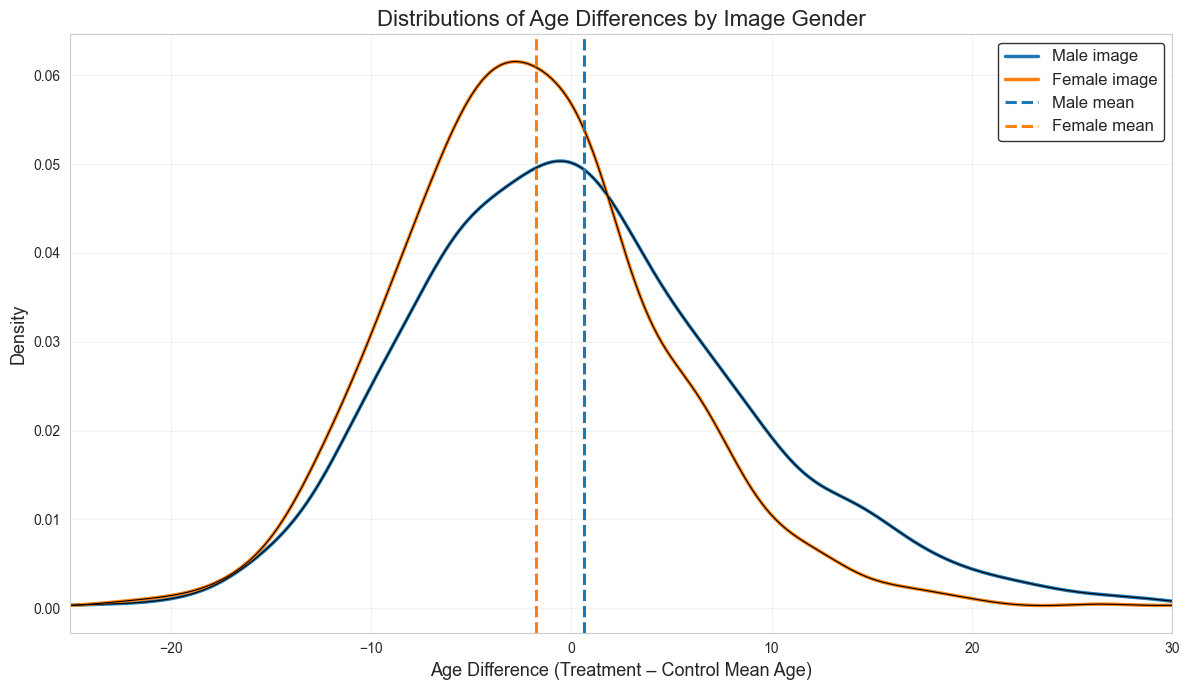

In [17]:
# 1. LOAD + CLEAN
from scipy.stats import gaussian_kde 

control = pd.read_csv("data/experiment_control.csv")
treatment = pd.read_csv("data/experiment_treatment.csv")

# Clean category & gender exactly as before
for df in [control, treatment]:
    df["category"] = df["category"].astype(str).str.strip().str.lower()
    df["gender"] = df["gender"].astype(str).str.strip().str.lower()

# 2. KDE PLOT SECTION 

# Compute control mean age per category
control_means = control.groupby("category")["age"].mean().rename("control_mean_age")

# Merge & compute age difference
treatment = treatment.merge(control_means, on="category", how="left")
treatment["age_diff"] = treatment["age"] - treatment["control_mean_age"]

# Extract groups
male_diff = treatment.loc[treatment["gender"] == "male", "age_diff"].dropna()
female_diff = treatment.loc[treatment["gender"] == "female", "age_diff"].dropna()

# Styled plot
plt.figure(figsize=(12, 7))

x_vals = np.linspace(-25, 30, 500)

male_kde = gaussian_kde(male_diff)
female_kde = gaussian_kde(female_diff)

plt.plot(x_vals, male_kde(x_vals), color="#1f77b4", linewidth=2.5, label="Male image")
plt.plot(x_vals, female_kde(x_vals), color="#ff7f0e", linewidth=2.5, label="Female image")

plt.plot(x_vals, male_kde(x_vals), color="black", linewidth=0.8)
plt.plot(x_vals, female_kde(x_vals), color="black", linewidth=0.8)

plt.axvline(male_diff.mean(), color="#1f77b4", linestyle="--", linewidth=2.2, label="Male mean")
plt.axvline(female_diff.mean(), color="#ff7f0e", linestyle="--", linewidth=2.2, label="Female mean")

plt.xlim(-25, 30)
plt.xlabel("Age Difference (Treatment – Control Mean Age)", fontsize=13)
plt.ylabel("Density", fontsize=13)
plt.title("Distributions of Age Differences by Image Gender", fontsize=16)

plt.grid(alpha=0.25)
plt.legend(fontsize=12, frameon=True, edgecolor="black")

plt.tight_layout()
plt.show()



#### T-Tests

In [19]:
from scipy import stats

# 1. Load data

treat = pd.read_csv("data/experiment_treatment.csv")
ctrl = pd.read_csv("data/experiment_control.csv")

# 2. Preprocess treatment data & encode image gender

treat_clean = treat[["age", "gender", "category"]].dropna()
treat_clean["image_gender"] = treat_clean["gender"].str.lower()
treat_clean = treat_clean[treat_clean["image_gender"].isin(["male", "female"])]
treat_clean["gender_code"] = treat_clean["image_gender"].map({"male": 0, "female": 1})

# 3. Control mean age per category

ctrl_means = ctrl.groupby("category")["age"].mean()

# 4. Helper: compute difference scores

def compute_diffs(df_treat_subset, ctrl_means_series):
    diffs = []
    for _, row in df_treat_subset.iterrows():
        cat = row["category"]
        if cat not in ctrl_means_series:
            continue
        diffs.append(row["age"] - ctrl_means_series[cat])
    return np.array(diffs, dtype=float)

# 5. TEST 1: Welch two-sample t-test (female vs male raw ages)

group_female = treat_clean[treat_clean["gender_code"] == 1]["age"]
group_male   = treat_clean[treat_clean["gender_code"] == 0]["age"]

t_welch, p_welch = stats.ttest_ind(group_female, group_male, equal_var=False)
mean_diff_welch = group_female.mean() - group_male.mean()


# 6. TEST 2: Image of WOMAN difference scores

diffs_female_img = compute_diffs(
    treat_clean[treat_clean["gender_code"] == 1], ctrl_means
)
t_female, p_female = stats.ttest_1samp(diffs_female_img, popmean=0)
mean_diff_female = diffs_female_img.mean()

# 7. TEST 3: Image of MAN difference scores

diffs_male_img = compute_diffs(
    treat_clean[treat_clean["gender_code"] == 0], ctrl_means
)
t_male, p_male = stats.ttest_1samp(diffs_male_img, popmean=0)
mean_diff_male = diffs_male_img.mean()

# 8. Display

results = pd.DataFrame({
    "Test": [
        "Female vs Male",
        "Treatment vs Control (Female)",
        "Treatment vs Control (Male)"
    ],
    "Mean Difference": [
        mean_diff_welch,
        mean_diff_female,
        mean_diff_male
    ],
    "t-value": [
        t_welch,
        t_female,
        t_male
    ],
    "p-value (two-tailed)": [
        p_welch,
        p_female,
        p_male
    ]
})

styled = results.style.format({
    "Mean Difference": "{:.3f}",
    "t-value": "{:.3f}",
    "p-value (two-tailed)": "{:.3e}"
}).set_caption("Statistical Test Summary")

styled


,Test,Mean Difference,t-value,p-value (two-tailed)
0,Female vs Male,-5.465,-19.069,5.240e-78
1,Treatment vs Control (Female),-1.749,-11.323,4.818e-29
2,Treatment vs Control (Male),0.641,3.420,6.374e-04


The above table verifies that:
> The participants who uploaded an image of a woman estimated the average age of an occupation to be 5.46 years younger than those who
> uploaded an image of a man, holding occupation
> constant. Moreover, uploading an image of a woman led the participants
> to estimate a significantly lower age for each occupation (by 1.75 years)
> compared with the control participants, whereas uploading an
> image of a man led the participants to estimate a significantly
> higher age for each occupation (by 0.64 years) compared with those
> in the control condition.

### Investigation Of Amplification

In [21]:
import statsmodels.formula.api as smf
# 1. Load & prepare dataset
treat = pd.read_csv("data/experiment_treatment.csv")
ctrl  = pd.read_csv("data/experiment_control.csv")

# Keep consistent columns and stack
cols = ["subj", "category", "age", "gender", "condition"]
df = pd.concat([treat[cols], ctrl[cols]], ignore_index=True)

# Drop rows with missing relevant values
df = df.dropna(subset=["subj", "category", "age", "gender", "condition"])

# Keep only Male / Female for gender
df["gender"] = df["gender"].str.strip()
df = df[df["gender"].isin(["Male", "Female"])]

# 2. Fit OLS regression:
#    age ~ condition * gender + category + subj
#    with Treatment coding and Male as reference for gender,
#    Control as reference for condition

formula = (
    'age ~ '
    'C(condition, Treatment(reference="Control"))'
    '* C(gender, Treatment(reference="Male"))'
    ' + C(category) + C(subj)'
)

model = smf.ols(formula, data=df).fit(cov_type="nonrobust")

# 3. Top summary block

now = datetime.now()
left_info = pd.DataFrame({
    'Label': [
        'Dep. Variable', 'Model', 'Method', 'Date', 'Time',
        'No. Observations', 'Df Residuals', 'Df Model', 'Covariance Type'
    ],
    'Value': [
        'age', 'OLS', 'Least Squares',
        now.strftime('%Y-%m-%d'), now.strftime('%H:%M:%S'),
        f"{int(model.nobs)}", f"{int(model.df_resid)}", f"{int(model.df_model)}",
        'Nonrobust'
    ]
})

fit_stats = pd.DataFrame({
    'Statistic': [
        'R-squared', 'Adj. R-squared', 'F-statistic',
        'Prob (F-statistic)', 'Log-Likelihood', 'AIC', 'BIC'
    ],
    'Value': [
        f"{model.rsquared:.3f}",
        f"{model.rsquared_adj:.3f}",
        f"{model.fvalue:.3e}",
        f"{model.f_pvalue:.3f}",
        f"{model.llf:.3f}",
        f"{model.aic:.3e}",
        f"{model.bic:.3e}"
    ]
})

# Basic Regression Data Table

max_len = max(len(left_info), len(fit_stats))
fit_html = "<table style='border-collapse: collapse; width:100%; font-family:Arial; font-size:14px;'>"
for i in range(max_len):
    left_text = f"{left_info.iloc[i,0]}: {left_info.iloc[i,1]}" if i < len(left_info) else ""
    right_text = f"{fit_stats.iloc[i,0]}: {fit_stats.iloc[i,1]}" if i < len(fit_stats) else ""
    fit_html += (
        "<tr>"
        f"<td style='padding:4px; border:1px solid black; text-align:left; vertical-align:top'>{left_text}</td>"
        f"<td style='padding:4px; border:1px solid black; text-align:left; vertical-align:top'>{right_text}</td>"
        "</tr>"
    )
fit_html += "</table>"

# 4. Full coefficients table

coeff_table_full = (
    model.summary2().tables[1]
    .rename(index={'const': 'Intercept'})
    .round(3)
)

coeff_html = "<table style='border-collapse: collapse; width:100%; font-family:Arial; font-size:14px;'>"

# Header row: Variable + stats columns

coeff_html += "<tr>" + "".join(
    f"<th style='border:1px solid black; padding:4px; text-align:left'>{col}</th>"
    for col in ["Variable"] + list(coeff_table_full.columns)
) + "</tr>"

# Data rows: every coefficient in the model

for idx, row in coeff_table_full.iterrows():
    coeff_html += (
        f"<tr><td style='border:1px solid black; padding:4px; text-align:left'>{idx}</td>"
    )
    for val in row:
        coeff_html += (
            f"<td style='border:1px solid black; padding:4px; text-align:left'>{val:.3f}</td>"
        )
    coeff_html += "</tr>"

coeff_html += "</table>"

# 5. Residual diagnostics

omnibus_stat, omnibus_p = omni_normtest(model.resid)
jb_stat, jb_p, skew, kurtosis = jarque_bera(model.resid)
dw = sm.stats.stattools.durbin_watson(model.resid)

resid_left = ['Omnibus','Prob(Omnibus)','Durbin-Watson','Jarque-Bera (JB)']
resid_right = ['Prob(JB)','Skew','Kurtosis','Cond. No.']
resid_values_left = [
    f"{omnibus_stat:.3f}",
    f"{omnibus_p:.3f}",
    f"{dw:.3f}",
    f"{jb_stat:.3f}"
]
resid_values_right = [
    f"{jb_p:.3f}",
    f"{skew:.3f}",
    f"{kurtosis:.3f}",
    f"{model.condition_number:.3f}"
]

resid_html = "<table style='border-collapse: collapse; width:100%; font-family:Arial; font-size:14px;'>"
for l in range(4):
    resid_html += (
        f"<tr><td style='padding:4px; border:1px solid black; text-align:left'>"
        f"{resid_left[l]}: {resid_values_left[l]}</td>"
        f"<td style='padding:4px; border:1px solid black; text-align:left'>"
        f"{resid_right[l]}: {resid_values_right[l]}</td></tr>"
    )
resid_html += "</table>"

# 6. Display everything

title = "<h3>Regression: age ~ condition * gender + category + subj</h3>"
display(HTML(f"{title}{fit_html}{coeff_html}{resid_html}"))


### Regression Model: `age` ~ category + subj
#### Predictions and Residuals Plots

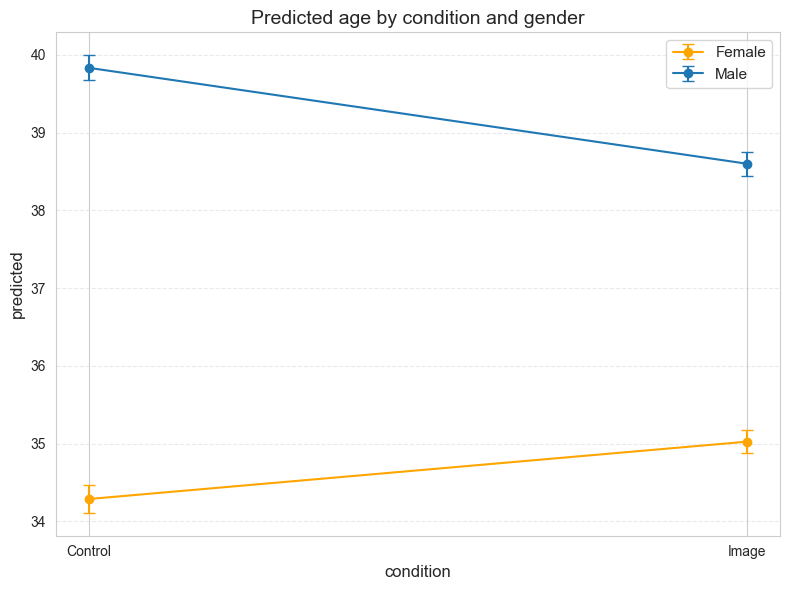

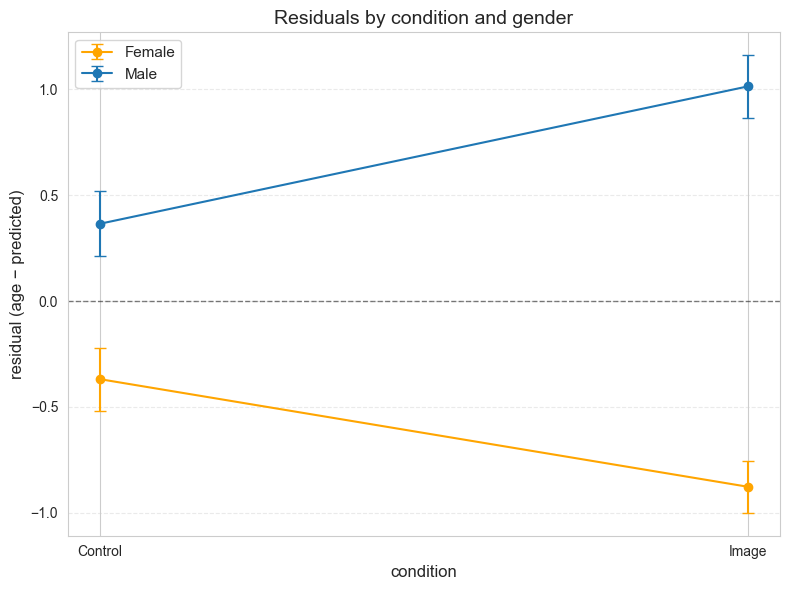

In [22]:

# 1. Load & prepare combined dataset
treat = pd.read_csv("data/experiment_treatment.csv")
ctrl  = pd.read_csv("data/experiment_control.csv")

cols = ["subj", "category", "age", "gender", "condition"]
df = pd.concat([treat[cols], ctrl[cols]], ignore_index=True)

# Clean
df = df.dropna(subset=["subj", "category", "age", "gender", "condition"])
df["gender"] = df["gender"].str.strip()
df = df[df["gender"].isin(["Male", "Female"])]

# 2. SECOND REGRESSION: age ~ category + subj

model2 = smf.ols("age ~ C(category) + C(subj)", data=df).fit()

# Predict age and compute residuals
df["predicted"] = model2.predict(df)
df["residual"] = df["age"] - df["predicted"]

# 3. Plot 1 – Predicted age by condition × gender
# Aggregate predictions by condition & gender

group_pred = (
    df.groupby(["condition", "gender"])["predicted"]
      .agg(["mean", "std", "count"])
      .reset_index()
)
group_pred["se"] = group_pred["std"] / np.sqrt(group_pred["count"])

conditions = ["Control", "Image"]
genders = ["Female", "Male"]
colors = {"Female": "orange", "Male": "tab:blue"}

plt.figure(figsize=(8, 6))

for gender in genders:
    sub = group_pred[group_pred["gender"] == gender].set_index("condition")
    sub = sub.loc[conditions] 

    plt.errorbar(
        conditions,
        sub["mean"],
        yerr=sub["se"],
        label=gender,
        marker="o",
        capsize=4,
        linestyle="-",
        color=colors[gender],
    )

plt.xlabel("condition", fontsize=12)
plt.ylabel("predicted", fontsize=12)
plt.title("Predicted age by condition and gender", fontsize=14)
plt.legend(title="", fontsize=11)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# 4. Plot 2 – Residuals by condition × gender

group_res = (
    df.groupby(["condition", "gender"])["residual"]
      .agg(["mean", "std", "count"])
      .reset_index()
)
group_res["se"] = group_res["std"] / np.sqrt(group_res["count"])

plt.figure(figsize=(8, 6))

for gender in genders:
    sub = group_res[group_res["gender"] == gender].set_index("condition")
    sub = sub.loc[conditions]

    plt.errorbar(
        conditions,
        sub["mean"],
        yerr=sub["se"],
        label=gender,
        marker="o",
        capsize=4,
        linestyle="-",
        color=colors[gender],
    )

plt.xlabel("condition", fontsize=12)
plt.ylabel("residual (age − predicted)", fontsize=12)
plt.title("Residuals by condition and gender", fontsize=14)
plt.axhline(0, color="black", linewidth=1, linestyle="--", alpha=0.5)
plt.legend(title="", fontsize=11)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


#### Predicted Age by Condition and Gender

The first plot shows predicted ages from a regression model that controls only for 
**category** and **subject**. After prediction, the values were grouped by 
**condition (Control vs. Image)** and **gender**.

- Predicted ages for **men** are consistently higher than for **women**.
- In the **Image** condition, predicted ages decrease for men and slightly increase for women.
- This pattern reflects the amplification effect: images of women lead to lower perceived age,
  and images of men lead to higher perceived age, even though gender and condition were not in the model.

---

#### Residuals by Condition and Gender

The second plot shows **residuals** (observed age − predicted age) grouped by condition and gender.

- **Women** show negative residuals → their ages tend to be **underestimated**.
- **Men** show positive residuals → their ages tend to be **overestimated**.
- These effects grow stronger in the **Image** condition, indicating that gendered images
  **amplify** age-estimation biases.

Even after accounting for category and subject, the condition × gender structure remains
visible in the residuals.


### ANOVA Models

In [23]:
from statsmodels.stats.anova import anova_lm

# 1. Load & prepare dataset

treat = pd.read_csv("data/experiment_treatment.csv")
ctrl  = pd.read_csv("data/experiment_control.csv")

cols = ["subj", "category", "age", "gender", "condition"]
df = pd.concat([treat[cols], ctrl[cols]], ignore_index=True)

df = df.dropna(subset=["subj", "category", "age", "gender", "condition"])
df["gender"] = df["gender"].str.strip()
df = df[df["gender"].isin(["Male", "Female"])]


# 2. Sum coding for condition and gender
#    (2-level factors: -1, +1)
# Condition: Control = -1, Image = +1

df["condition_sum"] = df["condition"].map({"Control": -1, "Image": 1})

# Gender: Male = -1, Female = +1

df["gender_sum"] = df["gender"].map({"Male": -1, "Female": 1})

# Helper to make ANOVA tables pretty in IPython

def pretty_anova(a):
    return (
        a.rename(columns={
            "sum_sq": "Sum Sq",
            "df": "df",
            "F": "F",
            "PR(>F)": "p-value"
        })
        .style.format({
            "Sum Sq": "{:.3f}",
            "F": "{:.3f}",
            "p-value": "{:.3e}"
        })
    )

# 3. FIRST ANOVA: age ~ condition * gender

model1 = smf.ols("age ~ condition_sum * gender_sum", data=df).fit()
anova1 = anova_lm(model1, typ=2) 

display(HTML("<h3>ANOVA Model 1: age ~ condition * gender (sum-coded)</h3>"))
display(pretty_anova(anova1))

# 4. SECOND ANOVA: age ~ condition * gender + category + subj

model2 = smf.ols("age ~ condition_sum * gender_sum + C(category) + C(subj)", data=df).fit()
anova2 = anova_lm(model2, typ=2)

display(HTML("<h3>ANOVA Model 2: age ~ condition * gender + category + subj (sum-coded)</h3>"))
display(pretty_anova(anova2))


,Sum Sq,df,F,p-value
condition_sum,57.586,1.000000,0.608,4.356e-01
gender_sum,71856.914,1.000000,758.523,5.017e-160
condition_sum:gender_sum,347.368,1.000000,3.667,5.554e-02
Residual,806175.482,8510.000000,nan,nan


,Sum Sq,df,F,p-value
C(category),230669.639,53.000000,95.764,0.000e+00
C(subj),456023.489,453.000000,22.150,0.000e+00
condition_sum,620.352,1.000000,13.650,2.217e-04
gender_sum,8055.026,1.000000,177.238,5.166e-40
condition_sum:gender_sum,329.074,1.000000,7.241,7.142e-03
Residual,363807.622,8005.000000,nan,nan


#### ANOVA Model 1: `age ~ condition * gender` (sum-coded)

The first ANOVA examines the effects of **condition**, **gender**, and their interaction on age estimates, without controlling for category or subject.

Key findings:

- **Gender has a very strong main effect** on age estimates  
  (`F = 758.523`, `p < 1e-158`).  
  Participants give substantially different age estimates for men vs. women.

- **Condition (Control vs. Image) does *not* show a significant main effect**  
  (`F = 0.608`, `p = 0.436`).  
  On average, condition alone does not shift age estimates when not controlling for anything else.

- The **condition × gender interaction is marginally significant**  
  (`F = 3.667`, `p ≈ 0.055`).  
  This suggests a weak tendency for the effect of condition to differ between men and women, but the evidence is not strong in this simple model.


---

#### ANOVA Model 2: `age ~ condition * gender + category + subj` (sum-coded)

The second ANOVA adds controls for **occupation category** and **subject**, removing large baseline differences.

Key findings:

- **Category** strongly predicts age (`F = 95.764`, `p < 1e-16`), meaning age expectations differ substantially between occupations.

- **Subject** also contributes significantly (`F = 22.150`, `p < 1e-16`), indicating individual variability in age estimation.

- After accounting for these factors, **condition becomes significant**  
  (`F = 13.650`, `p = 2.2e-4`).  
  This means the experimental manipulation (Image vs. Control) *does* influence age estimates once category and subject baselines are controlled.

- **Gender remains highly significant**  
  (`F = 177.238`, `p < 1e-38`).  
  Participants systematically estimate male and female ages differently.

- The **condition × gender interaction becomes clearly significant**  
  (`F = 7.241`, `p = 0.007`).  
  This shows that the effect of the Image condition depends on gender:  
  treatment amplifies gender-based shifts in perceived age.

---

#### Summary

- In the simple model (Model 1), only **gender** is strongly influential; the interaction is weak.  
- After adjusting for occupation and subject (Model 2), **condition**, **gender**, and their **interaction** all become statistically significant.  
- This supports the interpretation that the **Image condition amplifies gender-related distortions** in age estimation.
